# Post-hoc Q-value Analysis - Clean Version

In [1]:
import os
import sys
from matplotlib import animation
sys.path.append("/home/mbortkie/repos/crl_subgoal/src")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

import functools
import distrax
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as display

from impls.agents import agents
from config import SRC_ROOT_DIR
from envs.block_moving_env import *
from train import *
from impls.utils.checkpoints import restore_agent, save_agent
from config import Config, ExpConfig
from envs import legal_envs
from impls.utils.networks import GCDiscreteActor

In [ ]:
# Configuration
EPISODE_LENGTH = 100
NUM_ENVS = 1024
CHECKPOINT = 50
RUN_NAME = f"DQN{CHECKPOINT}_investigation"

# Model path template - use {num_boxes} as placeholder for the number of boxes
# Change only this line to switch between different model directories
MODEL_PATH_TEMPLATE = "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_{num_boxes}_grid_4_ep_len__filter_"
# Alternative: "/home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044157/runs/dqn_1.38_{num_boxes}_grid_4_ep_len__filter_quarter"

FIGURES_PATH = f"/home/mbortkie/repos/crl_subgoal/notebooks/figures/{RUN_NAME}"

os.makedirs(FIGURES_PATH, exist_ok=True)
Q_VALUE_MODE = 'mean'  # Options: 'mean' (average of Q1 and Q2) or 'diff' (absolute difference between Q1 and Q2)
MAKE_GIFS = False

In [3]:
def display_gif(env, timesteps, idx):
    grid_size = timesteps.grid.shape[-2:]
    fig, ax = plt.subplots(figsize=grid_size)
    # Assets are in repo root, not in src
    assets_path = os.path.join(os.path.dirname(SRC_ROOT_DIR), 'assets')
    animate = functools.partial(env.animate, ax, jax.tree_util.tree_map(lambda x: x[:,idx:].swapaxes(1, 0), timesteps), img_prefix=assets_path)
    anim = animation.FuncAnimation(fig, animate, frames=EPISODE_LENGTH, interval=80, repeat=False)
    gif_path = f"/tmp/block_moving_epoch.gif"
    anim.save(gif_path, writer='pillow')
    plt.close()
    display.display(display.Image(filename=gif_path))

def plot_q_value_difference(agent, states, goals, actions, episode_length, num_envs, 
                           return_data=False, mode='mean'):
    """Plot Q-values over timesteps.
    
    Args:
        agent: The agent with the critic network
        states: Environment states
        goals: Goal states
        actions: Actions taken
        episode_length: Length of episodes
        num_envs: Number of parallel environments
        return_data: If True, return data instead of plotting
        mode: Either 'mean' (average of Q1 and Q2) or 'diff' (absolute difference between Q1 and Q2)
    
    Returns:
        If return_data is True, returns (q_metric, q_metric_std_error)
    """
    traj_states_flat = states.reshape((states.shape[0] * states.shape[1], -1))
    traj_goals_flat = goals.reshape((goals.shape[0] * goals.shape[1], -1))
    traj_actions_flat = actions.reshape((actions.shape[0] * actions.shape[1]))
    
    q1, q2 = agent.network.select('critic')(traj_states_flat, traj_goals_flat, traj_actions_flat)
    q1 = q1.reshape((episode_length, num_envs))
    q2 = q2.reshape((episode_length, num_envs))
    
    if mode == 'diff':
        # Absolute difference between Q1 and Q2
        q_metric = jnp.mean(jnp.abs(q1 - q2), axis=1)
        q_metric_std_error = jnp.std(jnp.abs(q1 - q2), axis=1) / jnp.sqrt(q1.shape[1])
        ylabel = 'Absolute Difference |Q1 - Q2|'
        title = 'Distance between Q1 and Q2 over Timesteps'
        label = '|Q1 - Q2|'
    elif mode == 'mean':
        # Mean of Q1 and Q2
        q_metric = jnp.mean(jnp.mean(jnp.stack([q1, q2]), axis=0), axis=1)
        q_metric_std_error = jnp.std(jnp.mean(jnp.stack([q1, q2]), axis=0), axis=1) / jnp.sqrt(q1.shape[1])
        ylabel = 'Mean Q-value'
        title = 'Mean Q-value (Q1 + Q2) / 2 over Timesteps'
        label = 'Mean Q-value'
    else:
        raise ValueError(f"Invalid mode: {mode}. Must be 'mean' or 'diff'")

    if return_data:
        return q_metric, q_metric_std_error
    
    plt.plot(q_metric, label=label)
    plt.fill_between(np.arange(len(q_metric)), q_metric - q_metric_std_error, 
                     q_metric + q_metric_std_error, alpha=0.2)
    plt.xlabel('Timestep')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def analyze_setup(agent, config, generator_special=False, show_plots=False, q_mode='diff'):
    """Run analysis for a given setup (simple or diagonal)."""
    # Update config
    config.env.generator_special = generator_special
    
    # Create env with updated config
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))
    
    keys = random.split(random.PRNGKey(0), NUM_ENVS)
    state, info = env.reset(keys)
    
    dummy_timestep = env.get_dummy_timestep(key)
    replay_buffer = jit_wrap(
        TrajectoryUniformSamplingQueue(
            max_replay_size=config.exp.max_replay_size,
            dummy_data_sample=dummy_timestep,
            sample_batch_size=config.exp.batch_size,
            num_envs=config.exp.num_envs,
            episode_length=config.env.episode_length,
        )
    )
    buffer_state = jax.jit(replay_buffer.init)(key)
    
    # Collect data
    data_key = random.PRNGKey(0)
    _, _, timesteps = collect_data(agent, data_key, env, config.exp.num_envs, config.env.episode_length, use_targets=config.exp.use_targets)
    buffer_state = replay_buffer.insert(buffer_state, timesteps)
    
    # Create batch
    jitted_flatten_batch = jax.jit(jax.vmap(flatten_batch, in_axes=(None, None, 0, 0)), static_argnums=(0, 1))
    jitted_create_batch = functools.partial(
        create_batch,
        gamma=config.exp.gamma,
        use_targets=config.exp.use_targets,
        use_future_and_random_goals=config.exp.use_future_and_random_goals,
        jitted_flatten_batch=jitted_flatten_batch,
        use_discounted_mc_rewards=config.agent.use_discounted_mc_rewards,
    )
    
    batch_key = random.PRNGKey(0)
    buffer_state, transitions = replay_buffer.sample(buffer_state)
    batch = jitted_create_batch(transitions, batch_key)
    
    # Compute entropy
    if show_plots:
        all_actions = jnp.tile(jnp.arange(6), (batch['observations'].shape[0], 1))
        qs = jax.lax.stop_gradient(
            jax.vmap(agent.network.select("critic"), in_axes=(None, None, 1))(batch['observations'], batch['value_goals'], all_actions)
        )
        qs = qs.min(axis=1).transpose(1, 0)
        dist = distrax.Categorical(logits=qs / jnp.maximum(1e-6, 1))
        
        plt.hist(dist.entropy())
        plt.title('Entropy Distribution')
        plt.show()
    
    # Process timesteps for Q-value analysis
    use_targets = False
    timesteps_tr = jax.lax.cond(
        use_targets,
        lambda: timesteps.replace(),
        lambda: timesteps.replace(
            grid=remove_targets(timesteps.grid),
            goal=remove_targets(timesteps.goal)
        )
    )
    
    tr_states = timesteps_tr.grid
    tr_actions = timesteps_tr.action
    tr_goals = timesteps_tr.goal
    
    # Get Q-value data using the specified mode
    q_metric, q_metric_std = plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS, return_data=True, mode=q_mode)
    
    if show_plots:
        plot_q_value_difference(agent, tr_states, tr_goals, tr_actions, EPISODE_LENGTH, NUM_ENVS, mode=q_mode)
    
    return env, timesteps, q_metric, q_metric_std

In [ ]:
# Initial config
config = Config(
    exp=ExpConfig(seed=0, name="test"),
    env=BoxPushingConfig(
        grid_size=4,
        number_of_boxes_min=1,
        number_of_boxes_max=1,
        number_of_moving_boxes_max=1
    )
)

env = create_env(config.env)
env = AutoResetWrapper(env)
key = random.PRNGKey(config.exp.seed)
env.step = jax.jit(jax.vmap(env.step))
env.reset = jax.jit(jax.vmap(env.reset))
dummy_timestep = env.get_dummy_timestep(key)

MODEL_PATH = MODEL_PATH_TEMPLATE.format(num_boxes=1)
# Construct model path for initial setup (1 box)

In [6]:
# Create example batch and restore agent
example_batch = {
    "observations": dummy_timestep.grid.reshape(1, -1),
    "next_observations": dummy_timestep.grid.reshape(1, -1),
    "actions": jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space - 1),
    "rewards": jnp.ones((1,), dtype=jnp.int8),
    "masks": jnp.ones((1,), dtype=jnp.int8),
    "value_goals": dummy_timestep.grid.reshape(1, -1),
    "actor_goals": dummy_timestep.grid.reshape(1, -1),
}

agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_50.pkl


# Analysis for All Box Counts (1-4)

In [7]:
# Store results for all box counts
results = {}

for num_boxes in [1, 2, 3, 4]:
    print(f"\n{'='*60}")
    print(f"Analyzing model trained on {num_boxes} boxes")
    print(f"{'='*60}\n")
    
    # Construct model path from template
    MODEL_PATH = MODEL_PATH_TEMPLATE.format(num_boxes=num_boxes)
    print(f"Loading model from: {MODEL_PATH}")
    
    # Update config
    config = Config(
        exp=ExpConfig(seed=0, name="test"),
        env=BoxPushingConfig(
            grid_size=4,
            number_of_boxes_min=num_boxes,
            number_of_boxes_max=num_boxes,
            number_of_moving_boxes_max=1
        )
    )
    
    env = create_env(config.env)
    env = AutoResetWrapper(env)
    key = random.PRNGKey(config.exp.seed)
    env.step = jax.jit(jax.vmap(env.step))
    env.reset = jax.jit(jax.vmap(env.reset))
    dummy_timestep = env.get_dummy_timestep(key)
    
    # Create example batch
    example_batch = {
        "observations": dummy_timestep.grid.reshape(1, -1),
        "next_observations": dummy_timestep.grid.reshape(1, -1),
        "actions": jnp.ones((1,), dtype=jnp.int8) * (env._env.action_space - 1),
        "rewards": jnp.ones((1,), dtype=jnp.int8),
        "masks": jnp.ones((1,), dtype=jnp.int8),
        "value_goals": dummy_timestep.grid.reshape(1, -1),
        "actor_goals": dummy_timestep.grid.reshape(1, -1),
    }
    
    # Restore agent
    agent, config = restore_agent(example_batch, MODEL_PATH, CHECKPOINT)
    
    # Run simple setup analysis
    print("Running simple setup analysis...")
    env_simple, timesteps_simple, q_metric_simple, q_metric_std_simple = analyze_setup(agent, config, generator_special=False, show_plots=False, q_mode=Q_VALUE_MODE)
    
    # Run diagonal setup analysis
    print("Running diagonal setup analysis...")
    env_diagonal, timesteps_diagonal, q_metric_diagonal, q_metric_std_diagonal = analyze_setup(agent, config, generator_special=True, show_plots=False, q_mode=Q_VALUE_MODE)
    
    # Store results
    results[num_boxes] = {
        'simple': (q_metric_simple, q_metric_std_simple),
        'diagonal': (q_metric_diagonal, q_metric_std_diagonal),
        'env_simple': env_simple,
        'timesteps_simple': timesteps_simple,
        'env_diagonal': env_diagonal,
        'timesteps_diagonal': timesteps_diagonal
    }
    
    print(f"✓ Completed analysis for {num_boxes} boxes")


Analyzing model trained on 1 boxes

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_1_grid_4_ep_len__filter_/params_50.pkl
Running simple setup analysis...


2025-10-03 00:19:50.984760: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Running diagonal setup analysis...
✓ Completed analysis for 1 boxes

Analyzing model trained on 2 boxes

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_2_grid_4_ep_len__filter_/params_50.pkl
Running simple setup analysis...
Running diagonal setup analysis...
✓ Completed analysis for 2 boxes

Analyzing model trained on 3 boxes

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_3_grid_4_ep_len__filter_/params_50.pkl
Running simple setup analysis...
Running diagonal setup analysis...
✓ Completed analysis for 3 boxes

Analyzing model trained on 4 boxes

Restored from /home/mbortkie/repos/crl_subgoal/experiments/stich_dqn_td_grid_4_20250917_044054/runs/dqn_1.38_4_grid_4_ep_len__filter_/params_50.pkl
Running simple setup analysis...
Running diagonal setup analysis...
✓ Completed analysis for 4 boxes


# Comparison Plots: Simple vs Diagonal Setup

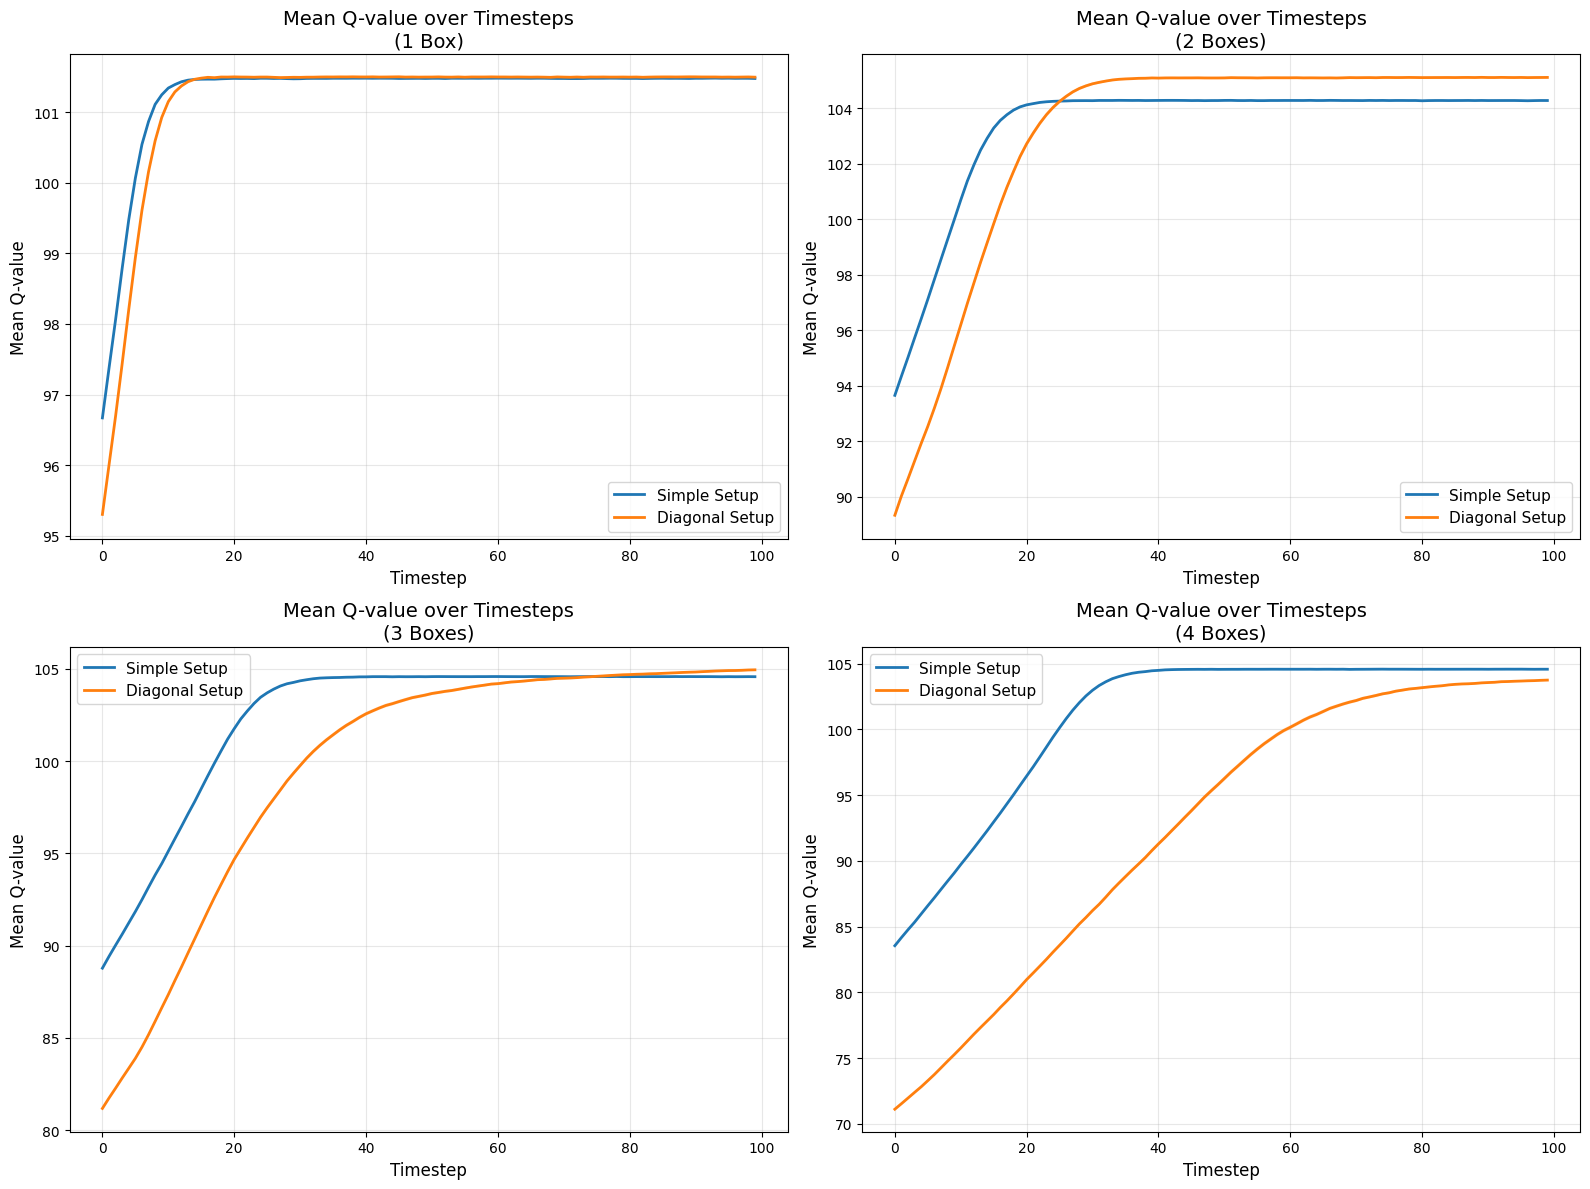

In [8]:
# Create comparison plots for each box count
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Set plot labels based on mode
if Q_VALUE_MODE == 'diff':
    ylabel = 'Absolute Difference'
    title_suffix = 'Distance between Q1 and Q2 over Timesteps'
elif Q_VALUE_MODE == 'mean':
    ylabel = 'Mean Q-value'
    title_suffix = 'Mean Q-value over Timesteps'
else:
    ylabel = 'Q-value Metric'
    title_suffix = 'Q-value Metric over Timesteps'

for idx, num_boxes in enumerate([1, 2, 3, 4]):
    ax = axes[idx]
    
    # Get data
    q_metric_simple, q_metric_std_simple = results[num_boxes]['simple']
    q_metric_diagonal, q_metric_std_diagonal = results[num_boxes]['diagonal']
    
    timesteps = np.arange(len(q_metric_simple))
    
    # Plot simple setup
    ax.plot(timesteps, q_metric_simple, label='Simple Setup', linewidth=2)
    ax.fill_between(timesteps, 
                     q_metric_simple - q_metric_std_simple, 
                     q_metric_simple + q_metric_std_simple, 
                     alpha=0.2)
    
    # Plot diagonal setup
    ax.plot(timesteps, q_metric_diagonal, label='Diagonal Setup', linewidth=2)
    ax.fill_between(timesteps, 
                     q_metric_diagonal - q_metric_std_diagonal, 
                     q_metric_diagonal + q_metric_std_diagonal, 
                     alpha=0.2)
    
    ax.set_xlabel('Timestep', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f'{title_suffix}\n({num_boxes} Box{"es" if num_boxes > 1 else ""})', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_PATH, f'comparison_all_boxes_{Q_VALUE_MODE}.png'), dpi=150, bbox_inches='tight')
plt.show()

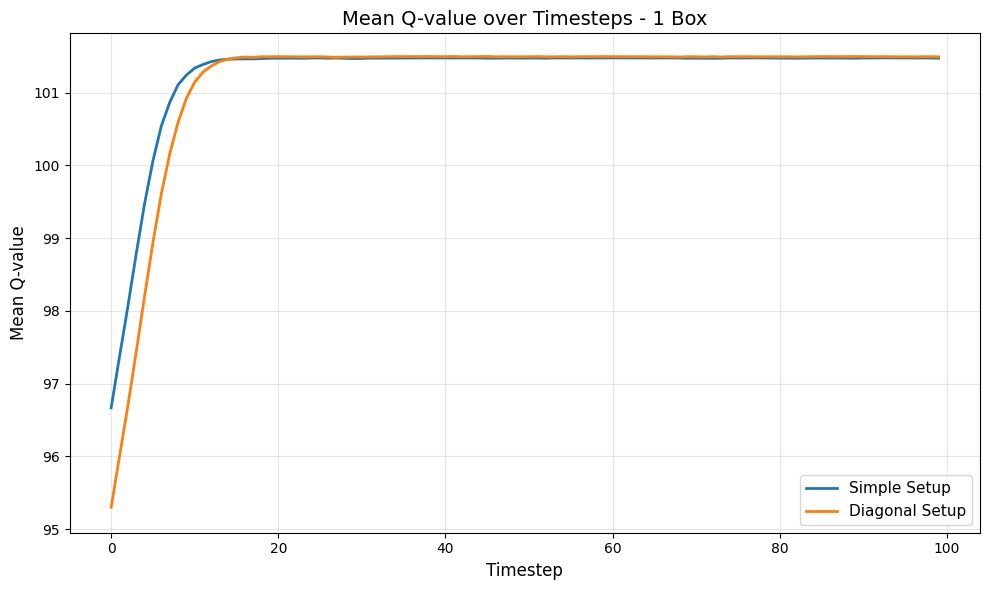

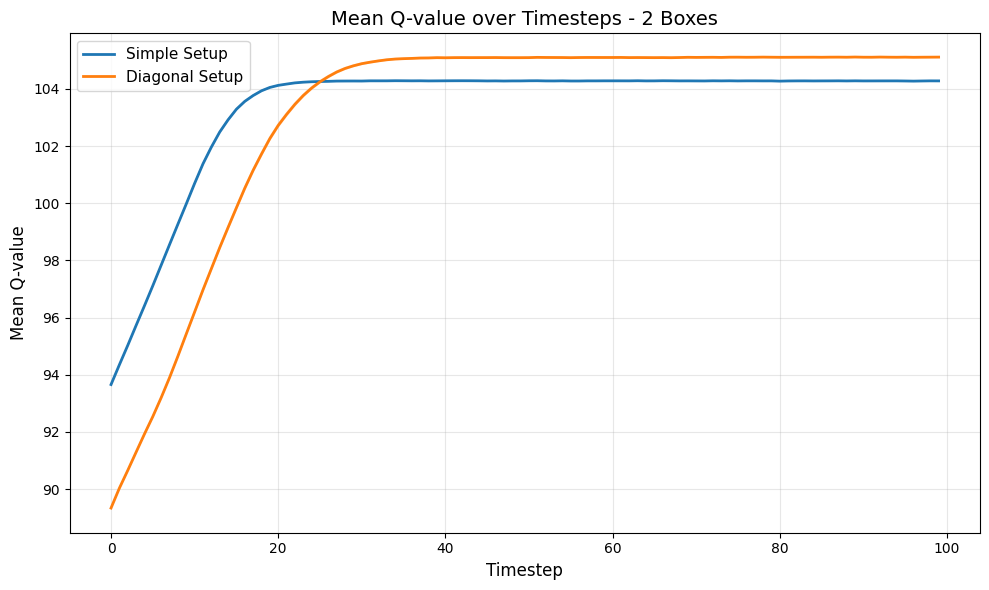

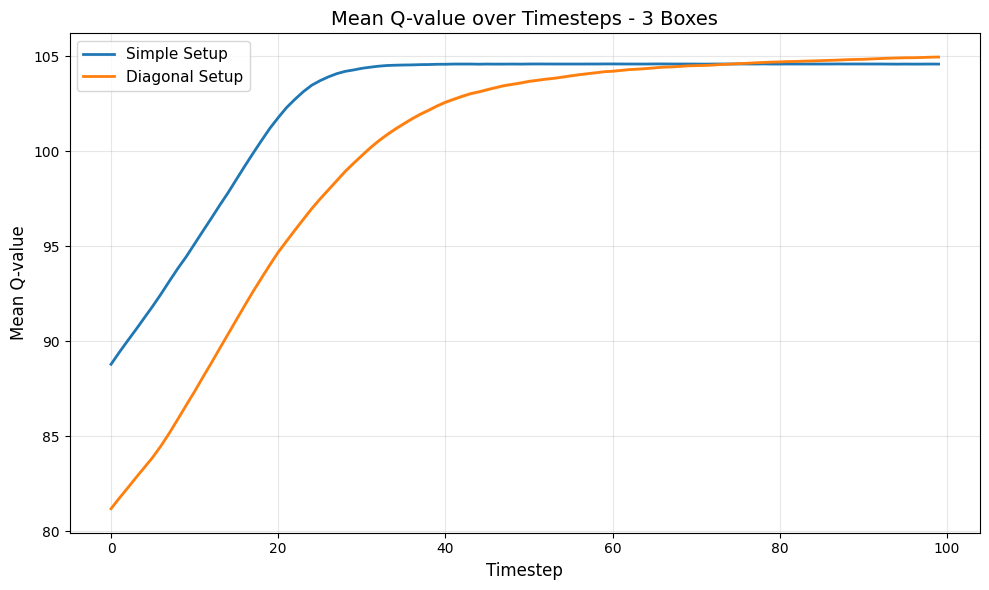

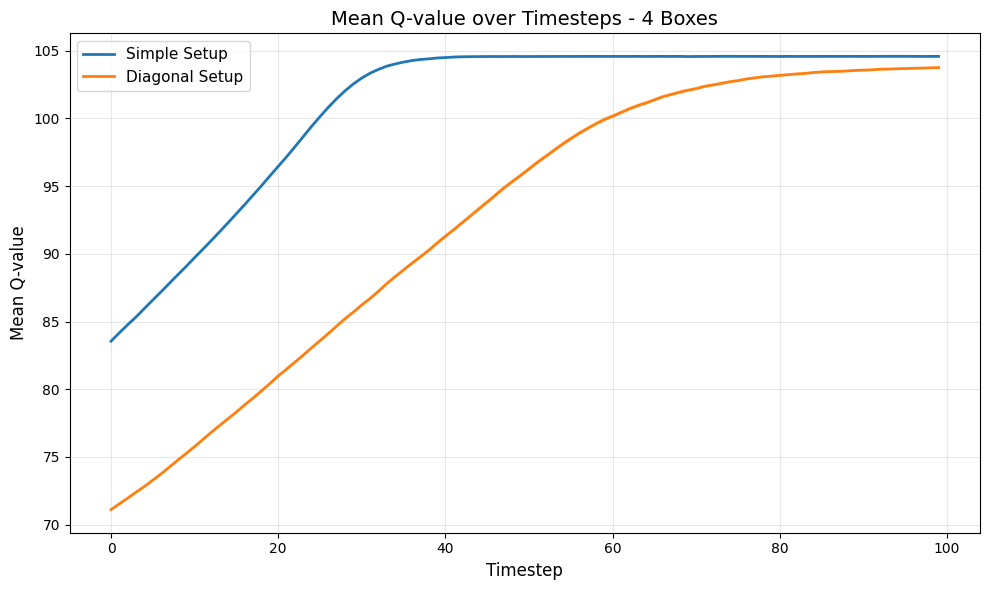

In [9]:
# Create individual plots for each box count (if needed)
# Set plot labels based on mode
if Q_VALUE_MODE == 'diff':
    ylabel = 'Absolute Difference'
    title_suffix = 'Distance between Q1 and Q2 over Timesteps'
elif Q_VALUE_MODE == 'mean':
    ylabel = 'Mean Q-value'
    title_suffix = 'Mean Q-value over Timesteps'
else:
    ylabel = 'Q-value Metric'
    title_suffix = 'Q-value Metric over Timesteps'

for num_boxes in [1, 2, 3, 4]:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get data
    q_metric_simple, q_metric_std_simple = results[num_boxes]['simple']
    q_metric_diagonal, q_metric_std_diagonal = results[num_boxes]['diagonal']
    
    timesteps = np.arange(len(q_metric_simple))
    
    # Plot simple setup
    ax.plot(timesteps, q_metric_simple, label='Simple Setup', linewidth=2)
    ax.fill_between(timesteps, 
                     q_metric_simple - q_metric_std_simple, 
                     q_metric_simple + q_metric_std_simple, 
                     alpha=0.2)
    
    # Plot diagonal setup
    ax.plot(timesteps, q_metric_diagonal, label='Diagonal Setup', linewidth=2)
    ax.fill_between(timesteps, 
                     q_metric_diagonal - q_metric_std_diagonal, 
                     q_metric_diagonal + q_metric_std_diagonal, 
                     alpha=0.2)
    
    ax.set_xlabel('Timestep', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(f'{title_suffix} - {num_boxes} Box{"es" if num_boxes > 1 else ""}', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_PATH, f'comparison_{num_boxes}_boxes_{Q_VALUE_MODE}.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Optional: Display Sample Trajectories

In [10]:
# Display sample trajectories for a specific box count (set MAKE_GIFS to True to enable)
if MAKE_GIFS:
    selected_boxes = 1  # Change this to view different box counts
    print(f"Displaying trajectories for {selected_boxes} box(es)")
    
    print("\nSimple Setup:")
    env_simple = results[selected_boxes]['env_simple']
    timesteps_simple = results[selected_boxes]['timesteps_simple']
    for idx in range(3):
        display_gif(env_simple, timesteps_simple, idx)
    
    print("\nDiagonal Setup:")
    env_diagonal = results[selected_boxes]['env_diagonal']
    timesteps_diagonal = results[selected_boxes]['timesteps_diagonal']
    for idx in range(3):
        display_gif(env_diagonal, timesteps_diagonal, idx)